# Overview
## Objective
The objective of the study is to identify the factors that affect obesity the most. To achieve this, three approaches are used: PCA, classification, and regression.

### Approaches

> - PCA is used to identify the factors that contribute the most to obesity.
> - Classification is used to identify the most important predictors of obesity.
> - Regression is used to identify the factors that contribute the most to an individual's BMI.

### Interpretation

To interpret the results, the SHAP approach is used in both classification and regression. SHAP values are used to explain the contribution of each feature to the target variable, providing a deeper understanding of the contribution of each feature to obesity.

### Overall

Overall, these three approaches work together to identify the most important factors that affect obesity. PCA identifies the most important features, classification identifies the most important predictors of obesity, and regression identifies the factors that contribute the most to an individual's BMI. The interpretation of the results using the SHAP approach provides a more detailed understanding of the contribution of each feature to obesity.

## Dataset Description
### About the dataset
This dataset include data for the estimation of obesity levels in individuals from the countries of Mexico, Peru and Colombia, based on their eating habits and physical condition. 77% of the data was generated synthetically using the Weka tool and the SMOTE filter, 23% of the data was collected directly from users through a web platform.

The data contains 17 attributes and 2111 records, the records are labeled with the class variable NObesity (Obesity Level), that allows classification of the data using the values of: 
* Insufficient Weight, 
* Normal Weight
* Overweight Level I
* Overweight Level II
* Obesity Type I
* Obesity Type II
* Obesity Type III


### Features Descriptions

| Feature Name                              | Description                                                            | Label                                           | Variable Type |
|-------------------------------------------|------------------------------------------------------------------------|-------------------------------------------------|---------------|
| Gender                                    | The gender of the individual                                          | Male or Female                                  | Categorical   |
| Age                                       | The age of the individual in years                                     | Years                                           | Numerical     |
| Height                                    | The height of the individual in centimeters                            | Centimeters                                     | Numerical     |
| Weight                                    | The weight of the individual in kilograms                              | Kilograms                                       | Numerical     |
| Family history with overweight            | Whether the individual has a family history of overweight              | Yes or No                                       | Categorical   |
| FAVC (Frequent consumption of high caloric food) | Whether the individual frequently consumes high-calorie foods        | Yes or No                                       | Categorical   |
| FCVC (Frequency of consumption of vegetables) | How frequently the individual consumes vegetables                       | Never, 1-2 days, 3-4 days, or every day        | Ordinal       |
| NCP (Number of main meals)                | The number of main meals that the individual consumes in a day         | 1, 2, 3, 4, or 5                               | Ordinal   |
| CAEC (Consumption of food between meals)   | Whether the individual consumes food between meals                      | No, Sometimes, or Frequently                  | Ordinal   |
| SMOKE (Smoking habit)                     | Whether the individual smokes or not                                    | Yes or No                                       | Categorical   |
| CH2O (Daily water consumption)            | The daily water consumption of the individual in liters                | Liters                                          | Ordinal     |
| SCC (Calories consumption monitoring)     | Whether the individual monitors their calorie consumption               | Yes or No       | Categorical   |
| FAF (Physical activity frequency)         | How frequently the individual engages in physical activity             | None, 1-2 days, 3-4 days, or 5 or more days   | Ordinal       |
| TUE (Time using technology devices)       | The amount of time the individual spends using technology devices      | 0, 1-2 hours, 3-4 hours, 5 or more hours      | Ordinal       |
| CALC (Consumption of alcohol)             | Whether the individual consumes alcohol                                 | No, Sometimes, or Frequently                  | Ordinal   |
| MTRANS (Transportation used)              | The mode of transportation used by the individual                      | Automobile, Motorbike, Bike, Public transportation, Walking, or Other | Categorical   |
| NObeyesdad                                | The obesity level of the individual based on BMI calculation           | Insufficient Weight, Normal Weight, Overweight Level I, Overweight Level II, Obesity Type I, Obesity Type II, or Obesity Type III | Categorical |


# Preparation & Cleanup

In [1]:
#General
import pandas as pd
import numpy as np

#Preprocessing
from sklearn import feature_selection
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold, cross_val_predict, StratifiedKFold, cross_validate, cross_val_score
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler

#Models
import xgboost as xgb
import lightgbm as lgb
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, gaussian_process, neural_network
from sklearn.decomposition import PCA


#Model_Evaluation
import optuna
import shap
from optuna.pruners import MedianPruner
from sklearn.metrics import roc_curve, auc, make_scorer, accuracy_score, precision_score, recall_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import f1_score, plot_confusion_matrix, classification_report, average_precision_score

#Visualization
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import plotly.figure_factory as ff
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots


#Setting_Parameters
import time
import warnings
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
from IPython.display import display, Markdown

def bold(string):
    display(Markdown(string))

simplefilter("ignore", category=ConvergenceWarning)    
optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', 'Solver terminated early.*')
sns.set()
style.use('ggplot')
pd.set_option("display.max_rows", 100)
%matplotlib inline 
plt.rcParams["figure.figsize"] = (8, 6)

The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.


In [2]:
df = pd.read_csv('/kaggle/input/obesity-levels/ObesityDataSet_raw_and_data_sinthetic.csv')
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [3]:
df.describe(include=np.object)

,Gender,family_history_with_overweight,FAVC,CAEC,SMOKE,SCC,CALC,MTRANS,NObeyesdad
count,2111,2111,2111,2111,2111,2111,2111,2111,2111
unique,2,2,2,4,2,2,4,5,7
top,Male,yes,yes,Sometimes,no,no,Sometimes,Public_Transportation,Obesity_Type_I
freq,1068,1726,1866,1765,2067,2015,1401,1580,351


In [4]:
df.describe()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,24.312600,1.701677,86.586058,2.419043,2.685628,2.008011,1.010298,0.657866
std,6.345968,0.093305,26.191172,0.533927,0.778039,0.612953,0.850592,0.608927
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,19.947192,1.630000,65.473343,2.000000,2.658738,1.584812,0.124505,0.000000
50%,22.777890,1.700499,83.000000,2.385502,3.000000,2.000000,1.000000,0.625350
75%,26.000000,1.768464,107.430682,3.000000,3.000000,2.477420,1.666678,1.000000
max,61.000000,1.980000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000


In [5]:
cols = {"Age":40,"FCVC": 3, "NCP": 4, "CH2O": 3, "FAF": 4, "TUE": 3}
for col,uniqs in cols.items():
    bold(f'**{col}** has **{len(df[col].unique())}** unique values instead of **{uniqs}** ')

**Age** has **1402** unique values instead of **40** 

**FCVC** has **810** unique values instead of **3** 

**NCP** has **635** unique values instead of **4** 

**CH2O** has **1268** unique values instead of **3** 

**FAF** has **1190** unique values instead of **4** 

**TUE** has **1129** unique values instead of **3** 

* Some of our descrete ordinal records are floats because they were syntheticly generated.
* We should convert these float to whole integers to better represent the survey data.

In [6]:
#Rounding floats to integers
for col, uniqs in cols.items():
    df[col] = round(df[col]).astype('int')

In [7]:
# Checking again
for col,uniqs in cols.items():
    bold(f'**{col}** has **{len(df[col].unique())}** unique values ')

**Age** has **40** unique values 

**FCVC** has **3** unique values 

**NCP** has **4** unique values 

**CH2O** has **3** unique values 

**FAF** has **4** unique values 

**TUE** has **3** unique values 

# Exploratory Data Analysis
This section will inspect the distributions of all the features and their impact on the target variable.

In [8]:

hist_data = [df['Age']]
group_labels = ['Age']

fig = ff.create_distplot(hist_data, group_labels, show_hist=False, show_rug=False)

# Customize the plot
#fig.update_traces(line=dict(color='royalblue', width=2))
fig.update_layout(
    title=dict(text='Age Distribution (KDE)', x=0.5, font=dict(size=24)),
    xaxis=dict(title='Age', title_font=dict(size=18), tickfont=dict(size=14)),
    yaxis=dict(title='Density', title_font=dict(size=18), tickfont=dict(size=14)),
    template='plotly_white',
    showlegend=False
)

fig.show()

In [9]:

attributes = df['NObeyesdad'].unique()

# Prepare the data
kde_data = []
for attr in attributes:
    kde = neighbors.KernelDensity(kernel='gaussian', bandwidth=1)
    data = df[df['NObeyesdad'] == attr]['Age'].values
    kde.fit(data[:, np.newaxis])
    X_plot = np.linspace(df['Age'].min(), df['Age'].max(), 1000)[:, np.newaxis]
    log_dens = kde.score_samples(X_plot)
    kde_data.append((attr,X_plot, np.exp(log_dens)))

# Create the plot
fig = go.Figure()

for attr, X_plot, density in kde_data:
    fig.add_trace(go.Scatter(x=X_plot[:, 0], y=density, mode='lines', name=attr))

# Customize the plot
fig.update_layout(
    title=dict(text='Age Distribution (KDE) by NObeyesdad', x=0.5, font=dict(size=24)),
    xaxis=dict(title='Age', title_font=dict(size=18), tickfont=dict(size=14)),
    yaxis=dict(title='Density', title_font=dict(size=18), tickfont=dict(size=14)),
    template='plotly_white',
    legend=dict(title='NObeyesdad', font=dict(size=14))
)

fig.show()

In [10]:

obesity_order = ['Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I',
                 'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III']

fig = px.box(df, x="NObeyesdad", y="Age",  category_orders={'NObeyesdad': obesity_order})

# Update the color of the box and whiskers
fig.update_traces(#boxmean=True,
                  jitter=0,
                  #whiskerwidth=0.2,
                  marker=dict(color='#2a9d8f', size=3),
                  line=dict(width=1.2)
                 )

# Update the layout
fig.update_layout(
    title=dict(text='Box Plot of Age by Obesity Status', x=0.5, font=dict(size=24)),
    xaxis_title="Obesity Status",
    yaxis_title="Age",
    template='plotly_white',
    width=800, # increase the width of the plot
    height=500, # increase the height of the plot
)

fig.show()


> We can clearly see that "AGE" can be an important factor in classifying obesity

In [11]:


columns = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE',
           'SCC', 'CALC', 'MTRANS', 'NObeyesdad']

for col in columns:
    df[col] = df[col].astype('category')

# Define a list of colors for the bars
#colors = ['#264653', '#2a9d8f', '#e9c46a', '#f4a261', '#e76f51', '#023047', '#8ecae6', '#fefae0', '#dda15e']

# Create a 3x3 grid of subplots
fig = make_subplots(rows=3, cols=3, subplot_titles=columns)

# Add bar plots for each categorical column
for idx, col in enumerate(columns):
    row, col_idx = divmod(idx, 3)
    counts = df[col].value_counts()
    fig.add_trace(go.Bar(x=counts.index, y=counts.values, name=col, showlegend=False, marker=dict(color='rgb(158,202,225)')), row=row+1, col=col_idx+1)

# Customize the plot
fig.update_layout(
    title=dict(text='Frequency Plots of Categorical Columns', x=0.5, font=dict(size=24)),
    template='plotly_white',
    height=1000,
    width=1000,
)

# Update axis titles and font size
for i in range(1, 10):
    fig.update_xaxes(title_text=columns[i-1], title_font=dict(size=12), tickfont=dict(size=9), row=divmod(i-1, 3)[0]+1, col=divmod(i-1, 3)[1]+1)
    fig.update_yaxes(title_text='Frequency', title_font=dict(size=12), tickfont=dict(size=9), row=divmod(i-1, 3)[0]+1, col=divmod(i-1,3)[1]+1)

# Show the plot
fig.show()


In [12]:
columns = ["FCVC", "NCP", "CH2O", "FAF", "TUE"]

# Create a 2x3 grid of subplots
fig = make_subplots(rows=2, cols=3, subplot_titles=columns)

# Add bar plots for each categorical column
for idx, col in enumerate(columns):
    row, col_idx = divmod(idx, 3)
    counts = df[col].value_counts()
    fig.add_trace(go.Bar(x=counts.index, y=counts.values, name=col, showlegend=False), row=row+1, col=col_idx+1)

    # Change the color of each bar plot
    fig.update_traces(marker_color='rgb(158,202,225)', row=row+1, col=col_idx+1)

# Customize the plot
fig.update_layout(
    title=dict(text='Frequency Plots of Ordinal Columns', x=0.5, font=dict(size=24)),
    template='plotly_white',
    height=800,
    width=1000,
    showlegend=True,
)

# Update axis titles and font size
for i in range(1, 6):
    fig.update_xaxes(title_text=columns[i-1], title_font=dict(size=12), tickfont=dict(size=10), row=divmod(i-1, 3)[0]+1, col=divmod(i-1, 3)[1]+1)
    fig.update_yaxes(title_text='Frequency', title_font=dict(size=12), tickfont=dict(size=10), row=divmod(i-1, 3)[0]+1, col=divmod(i-1,3)[1]+1)

# Show the plot
fig.show()


# PCA
PCA (Principal Component Analysis) is a statistical technique used to reduce the complexity of high-dimensional data by identifying the most important variables that explain the variance in the dataset. 

In the context of this study, PCA is used to identify the factors that contribute the most to obesity. By analyzing the relationships among the different features in the dataset, PCA can identify which features are most strongly correlated with obesity and which ones can be disregarded.

## Preprocessing

In [13]:
X = df.drop(["Weight", "Height", "NObeyesdad"], axis=1)

> We firstly dropped our target variable **NObeyesdad**, and since it has been infered from the **Height** and **Weight** column using BMI calculation, we dropped them too

In [14]:
# Scale numerical variables
scaler = StandardScaler()
X_toScale = X.select_dtypes(include=['float64', 'int64'])
X_scaled = pd.DataFrame(scaler.fit_transform(X_toScale), columns=X_toScale.columns)
X_scaled.head()

,Age,FCVC,NCP,CH2O,FAF,TUE
0,-0.521741,-0.725454,0.385644,-0.021330,-1.124415,0.497717
1,-0.521741,0.987559,0.385644,1.431202,2.226606,-0.986295
2,-0.207057,-0.725454,0.385644,-0.021330,1.109599,0.497717
3,0.422312,0.987559,0.385644,-0.021330,1.109599,-0.986295
4,-0.364399,-0.725454,-2.085053,-0.021330,-1.124415,-0.986295


> We scaled the numerical variables of our dataset to improve the results of PCA.

In [15]:
dummies_cols = X[["Gender","family_history_with_overweight",
                                          "FAVC","CAEC","SMOKE","SCC","CALC","MTRANS"]]

X_dummies = pd.get_dummies(dummies_cols,columns=["Gender","family_history_with_overweight",
                                          "FAVC","CAEC","SMOKE","SCC","CALC","MTRANS"], drop_first=True)
X_dummies.head()

,Gender_Male,family_history_with_overweight_yes,FAVC_yes,CAEC_Frequently,CAEC_Sometimes,CAEC_no,SMOKE_yes,SCC_yes,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0
1,0,1,0,0,1,0,1,1,0,1,0,0,0,1,0
2,1,1,0,0,1,0,0,0,1,0,0,0,0,1,0
3,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1
4,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0


> As for our categorical variables, they have been encoded using one hot encoding and turned into dummy variables, it should be noted that we dropped one attribute from each feature to prevent Multicolinearity

In [16]:
# Combine the encoded categorical and scaled numerical features
X_final = pd.concat([X_scaled, X_dummies], axis=1)
X_final.head()

,Age,FCVC,NCP,CH2O,FAF,TUE,Gender_Male,family_history_with_overweight_yes,FAVC_yes,CAEC_Frequently,...,CAEC_no,SMOKE_yes,SCC_yes,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,-0.521741,-0.725454,0.385644,-0.021330,-1.124415,0.497717,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0
1,-0.521741,0.987559,0.385644,1.431202,2.226606,-0.986295,0,1,0,0,...,0,1,1,0,1,0,0,0,1,0
2,-0.207057,-0.725454,0.385644,-0.021330,1.109599,0.497717,1,1,0,0,...,0,0,0,1,0,0,0,0,1,0
3,0.422312,0.987559,0.385644,-0.021330,1.109599,-0.986295,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
4,-0.364399,-0.725454,-2.085053,-0.021330,-1.124415,-0.986295,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0


## Modelling

In [17]:
# Perform PCA
pca = PCA()
pca.fit(X_final)

PCA()

In [18]:
# Get the explained variance ratio for each component
explained_variance_ratio = pca.explained_variance_ratio_

# Print the explained variance ratio for each component
for i, ratio in enumerate(explained_variance_ratio):
    print(f'Explained variance ratio of component {i+1}: {ratio:.2%}')

Explained variance ratio of component 1: 18.71%
Explained variance ratio of component 2: 15.99%
Explained variance ratio of component 3: 13.71%
Explained variance ratio of component 4: 12.37%
Explained variance ratio of component 5: 11.61%
Explained variance ratio of component 6: 9.86%
Explained variance ratio of component 7: 5.22%
Explained variance ratio of component 8: 3.33%
Explained variance ratio of component 9: 2.66%
Explained variance ratio of component 10: 1.70%
Explained variance ratio of component 11: 1.36%
Explained variance ratio of component 12: 1.17%
Explained variance ratio of component 13: 0.62%
Explained variance ratio of component 14: 0.52%
Explained variance ratio of component 15: 0.44%
Explained variance ratio of component 16: 0.27%
Explained variance ratio of component 17: 0.25%
Explained variance ratio of component 18: 0.09%
Explained variance ratio of component 19: 0.07%
Explained variance ratio of component 20: 0.04%
Explained variance ratio of component 21: 0.

## Model Evaluation

In [19]:
# cumulative explained variance ratio
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# create trace for line with markers
trace = go.Scatter(x=list(range(1, len(cumulative_variance_ratio)+1)), 
                   y=cumulative_variance_ratio,
                   mode='lines+markers',
                   marker=dict(size=8, color='#2a9d8f'),
                   line=dict(width=1.2)
                  )

# create layout
layout = go.Layout(title=dict(text='Cumulative Explained Variance Ratio', x=0.5, font=dict(size=24)),
                   xaxis=dict(title='Number of Components'),
                   yaxis=dict(title='Cumulative Explained Variance Ratio'),
                   template='plotly_white',
                   width=800, # increase the width of the plot
                   height=500, # increase the height of the plot
                  )

# create figure
fig = go.Figure(data=[trace], layout=layout)

# show figure
fig.show()


> We can see that the first 5 components explain more than 70% of the variablility.

In [20]:
# Look at loadings for each component
loadings = pd.DataFrame(pca.components_, columns=X_final.columns)

# Determine components with highest explained variance ratios
variances = pca.explained_variance_ratio_
highest_variances = np.argsort(variances)[::-1][:5]
print("Highest variance components: ", highest_variances)

# Look at variables with highest loadings for each of the most important components
for component in highest_variances:
    top_variables = loadings.iloc[component].sort_values(ascending=False)[:5]
    print(f"\nComponent {component} - Top Variables:\n{top_variables}")

# Consider relationships between prominent variables and outcome variable


Highest variance components:  [0 1 2 3 4]

Component 0 - Top Variables:
Age                                   0.652307
FCVC                                  0.077632
family_history_with_overweight_yes    0.036282
CALC_Sometimes                        0.029018
CAEC_Sometimes                        0.028276
Name: 0, dtype: float64

Component 1 - Top Variables:
CH2O    0.565114
NCP     0.452785
FAF     0.425349
FCVC    0.344828
Age     0.181481
Name: 1, dtype: float64

Component 2 - Top Variables:
NCP            0.331819
Age            0.281140
FAF            0.234547
Gender_Male    0.195991
CALC_no        0.036073
Name: 2, dtype: float64

Component 3 - Top Variables:
CH2O           0.659154
FAF            0.086353
Gender_Male    0.073348
CAEC_no        0.035755
CALC_no        0.029883
Name: 3, dtype: float64

Component 4 - Top Variables:
FAF                0.722431
FCVC               0.151864
CALC_no            0.149160
Age                0.052581
CAEC_Frequently    0.041599
Name: 4, dty

In [21]:
# Get the loadings of the significant components
loadings = pca.components_

# Create a DataFrame to store the loadings
loadings_df = pd.DataFrame(loadings, columns=X_final.columns)

# Identify the variables with the highest loadings in each component
component_vars = []
for i in range(len(loadings)):
    component_vars.append(list(loadings_df.iloc[i].nlargest(5).index))

# Determine the cumulative explained variance ratio for each component
cumulative_var_ratio = np.cumsum(pca.explained_variance_ratio_)

# Create a summary table
summary_df = pd.DataFrame({
    'Component': range(1, len(loadings)+1),
    'Explained Variance Ratio': pca.explained_variance_ratio_,
    'Cumulative Explained Variance Ratio': cumulative_var_ratio,
    'Top Variables': component_vars
})

# Print the summary table
summary_df.head(6)


,Component,Explained Variance Ratio,Cumulative Explained Variance Ratio,Top Variables
0,1,0.187095,0.187095,"[Age, FCVC, family_history_with_overweight_yes..."
1,2,0.159892,0.346987,"[CH2O, NCP, FAF, FCVC, Age]"
2,3,0.137135,0.484122,"[NCP, Age, FAF, Gender_Male, CALC_no]"
3,4,0.123735,0.607857,"[CH2O, FAF, Gender_Male, CAEC_no, CALC_no]"
4,5,0.116068,0.723925,"[FAF, FCVC, CALC_no, Age, CAEC_Frequently]"
5,6,0.098592,0.822517,"[TUE, Age, FCVC, family_history_with_overweigh..."


Based on the top variables for each component, we can conclude the following:

* Component 0 is heavily influenced by **Age** and has a moderate positive correlation with **FCVC**, and a small positive correlation with **family_history_with_overweight_yes**, **CALC_Sometimes**, and **CAEC_Sometimes**.
* Component 1 is strongly influenced by **CH2O** and has moderate positive correlations with **NCP** and **FAF**, and a small positive correlation with **FCVC** and **Age**.
* Component 2 is moderately influenced by **NCP** and **Age** and has small positive correlations with **FAF** and **Gender_Male**, and a very small positive correlation with **CALC_no**.
* Component 3 is strongly influenced by **CH2O** and has small positive correlations with **FAF** and **Gender_Male**, and very small positive correlations with **CAEC_no** and **CALC_no**.
* Component 4 is strongly influenced by **FAF** and has a moderate positive correlation with **FCVC**, a small positive correlation with **CALC_no**, and a very small positive correlation with **Age** and **CAEC_Frequently**.

These results suggest that **Age**, **CH2O**, **FAF**, **FCVC**, **NCP**, **Gender_Male**, **family_history_with_overweight_yes** are the most important variables in determining obesity status in the dataset. However, it is important to note that the interpretation of PCA results can be challenging and should be interpreted with caution. Further analysis and experimentation may be required to validate these findings.



# Classification

Classification is a machine learning technique that involves predicting the class of an object based on its features. 

In this study, multiple classification algorithms are used on the 'NObeyesdad' feature as the target variable. By training different classifiers on the dataset, the study aims to identify the most important features that predict obesity. 

To interpret the results of the classification, the SHAP (SHapley Additive exPlanations) approach is used. SHAP values are used to explain the contribution of each feature to the classification decision. This helps to understand which features are most important in predicting obesity.

## Preprocessing

In [22]:
X = df.drop(["Weight", "Height", "NObeyesdad"], axis=1)
y = df["NObeyesdad"]

In [23]:
# Create a dictionary to map obesity status to a numerical value based on obesity severity
obesity_status_mapping = {
    'Insufficient_Weight': 0,
    'Normal_Weight': 1,
    'Overweight_Level_I': 2,
    'Overweight_Level_II': 3,
    'Obesity_Type_I': 4,
    'Obesity_Type_II': 5,
    'Obesity_Type_III': 6
}

# Map the obesity status to numerical values based on obesity severity
y = y.map(obesity_status_mapping)
y.head()

0    1
1    1
2    1
3    2
4    3
Name: NObeyesdad, dtype: category
Categories (7, int64): [0, 1, 4, 5, 6, 2, 3]

In [24]:
dummies_cols = X[["Gender","family_history_with_overweight",
                                          "FAVC","CAEC","SMOKE","SCC","CALC","MTRANS"]]

X_dummies = pd.get_dummies(dummies_cols,columns=["Gender","family_history_with_overweight",
                                          "FAVC","CAEC","SMOKE","SCC","CALC","MTRANS"], drop_first=True)

X_num = X.select_dtypes(include=['float64', 'int64'])


X = pd.concat([X_num, X_dummies], axis=1)
X.head()

,Age,FCVC,NCP,CH2O,FAF,TUE,Gender_Male,family_history_with_overweight_yes,FAVC_yes,CAEC_Frequently,...,CAEC_no,SMOKE_yes,SCC_yes,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,21,2,3,2,0,1,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0
1,21,3,3,3,3,0,0,1,0,0,...,0,1,1,0,1,0,0,0,1,0
2,23,2,3,2,2,1,1,1,0,0,...,0,0,0,1,0,0,0,0,1,0
3,27,3,3,2,2,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
4,22,2,1,2,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [25]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=23, stratify=y)

bold(f' X_train: {X_train.shape[0]}  |  y_train: {y_train.shape[0]}')
bold(f' X_test :  {X_test.shape[0]}  |  y_test: {y_test.shape[0]}')

 X_train: 1688  |  y_train: 1688

 X_test :  423  |  y_test: 423

In [26]:
#Scaling the numerical columns of train set and test set separatly to prevent data leakage
cols = ["Age", "FCVC", "NCP", "CH2O", "FAF", "TUE"]

std_scaler = StandardScaler()

X_train[cols] = std_scaler.fit_transform(X_train[cols])
X_test[cols] = std_scaler.transform(X_test[cols])

bold(f' X_train: {X_train.shape[0]}')
bold(f' X_test :  {X_test.shape[0]}')

 X_train: 1688

 X_test :  423

> We chose to scale the train and test sets separately to prevent data leakage

In [27]:
%%time
#Initializing the Folds, the Classifier and the RFECV algorithm
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=23)
clf = ensemble.RandomForestClassifier(n_jobs=-1, random_state=23) 
rfecv = RFECV(estimator=clf, step=1, cv=cv, scoring='accuracy', verbose=1, n_jobs=-1)   #10-fold cross-validation

rfecv = rfecv.fit(X_train, y_train)
cols = X_train.columns[rfecv.support_]
bold(f'Optimal number of features is **{rfecv.n_features_}** from {X_train.shape[1]} available')


Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.


Optimal number of features is **16** from 21 available

CPU times: user 2.65 s, sys: 496 ms, total: 3.15 s
Wall time: 48.7 s


> We performed [RFECV](https://www.scikit-yb.org/en/latest/api/model_selection/rfecv.html) to chose the best feature subset for our classification problem, this resulted in keeping **16** features out of the **21** original features.

In [28]:
keep_cols = X_train.columns[rfecv.support_]
features_dropped = [x for x in X_train.columns if x not in keep_cols]

X_train = X_train[keep_cols]
X_test = X_test[keep_cols]

bold('**Features dropped** :\n')
for col in features_dropped:
    print(col)
print('\n')
bold('**Features kept** :\n')
for col in keep_cols:
    print(col)

**Features dropped** :


CAEC_no
SMOKE_yes
MTRANS_Bike
MTRANS_Motorbike
MTRANS_Walking




**Features kept** :


Age
FCVC
NCP
CH2O
FAF
TUE
Gender_Male
family_history_with_overweight_yes
FAVC_yes
CAEC_Frequently
CAEC_Sometimes
SCC_yes
CALC_Frequently
CALC_Sometimes
CALC_no
MTRANS_Public_Transportation


## Modelling


### Model Selection

In [29]:
%%time
random_state = 23

# create a list of classifiers
classifiers = [
    tree.DecisionTreeClassifier(random_state=random_state),
    ensemble.RandomForestClassifier(random_state=random_state),
    linear_model.LogisticRegression(random_state=random_state),
    ensemble.AdaBoostClassifier(random_state=random_state),
    svm.SVC(random_state=random_state),
    svm.LinearSVC(random_state=random_state),
    neighbors.KNeighborsClassifier(),
    lgb.LGBMClassifier(random_state=random_state),
    xgb.XGBClassifier(random_state=random_state),
    neural_network.MLPClassifier(random_state=random_state)
]

# create a list of classifiers to evaluate
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=23)

# define the metrics to be computed
scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

#create table to compare MLA metrics
MLA_columns = ['Name','Accuracy','Recall', 'Precision', 'F1_score', 'Accuracy_std', 'Fit Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

# perform cross-validation and compute metrics
row_index = 0
cv_results_list = []
for clf in classifiers:
    cv_results = cross_validate(clf, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
    cv_results_list.append(cv_results)
    
    MLA_name = clf.__class__.__name__
    MLA_compare.loc[row_index, 'Name'] = MLA_name
    MLA_compare.loc[row_index, 'Accuracy'] = round(cv_results['test_accuracy'].mean(), 3)
    MLA_compare.loc[row_index, 'Recall'] = round(cv_results['test_recall_macro'].mean(), 3)
    MLA_compare.loc[row_index, 'Precision'] = round(cv_results['test_precision_macro'].mean(), 3)
    MLA_compare.loc[row_index, 'F1_score'] = round(cv_results['test_f1_macro'].mean(), 3)
    MLA_compare.loc[row_index, 'Accuracy_std'] = round(cv_results['test_accuracy'].std(), 3)
    MLA_compare.loc[row_index, 'Fit Time'] = round(cv_results['fit_time'].sum(), 3)
    
    
    print(f'{MLA_name} is done in {round(cv_results["fit_time"].sum(), 3)}')
    
    row_index+=1

MLA_compare.sort_values(by = ['Accuracy'], ascending = False, inplace = True)
MLA_compare

DecisionTreeClassifier is done in 0.106
RandomForestClassifier is done in 3.767
LogisticRegression is done in 1.689
AdaBoostClassifier is done in 1.844
SVC is done in 1.757
LinearSVC is done in 4.587
KNeighborsClassifier is done in 0.045
LGBMClassifier is done in 17.841
XGBClassifier is done in 59.182
MLPClassifier is done in 66.039
CPU times: user 732 ms, sys: 38.2 ms, total: 770 ms
Wall time: 48.8 s


,Name,Accuracy,Recall,Precision,F1_score,Accuracy_std,Fit Time
1,RandomForestClassifier,0.805,0.803,0.802,0.8,0.039,3.767
7,LGBMClassifier,0.797,0.795,0.793,0.792,0.03,17.841
8,XGBClassifier,0.795,0.792,0.791,0.788,0.034,59.182
9,MLPClassifier,0.731,0.728,0.721,0.72,0.034,66.039
0,DecisionTreeClassifier,0.728,0.723,0.72,0.719,0.029,0.106
4,SVC,0.723,0.719,0.715,0.71,0.035,1.757
6,KNeighborsClassifier,0.678,0.672,0.666,0.653,0.027,0.045
2,LogisticRegression,0.591,0.583,0.576,0.56,0.026,1.689
5,LinearSVC,0.571,0.561,0.564,0.522,0.023,4.587
3,AdaBoostClassifier,0.401,0.393,0.407,0.368,0.038,1.844


> We applied a 10 classification algorithms using 10 fold cross-validation on our training set, the results show clear superiority of ensemble methods over other methods.
> 
> We chose **RandomForestClassifier** and **LGBMClassifier** for further analysis.

### Hyperparameter Tuning

In [30]:
def objective(trial, mod, X_train, y_train, scorer= 'accuracy', folds=5):
    """
    THIS IS THE OBJECTIVE FUNCTION THAT RETURNS THE MEAN SCORES OF THE MODEL TO OPTUNA 
    FOR HYPERPARAMETER OPTIMIZATION
    """
    
    cv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=23)
    
    X = X_train.copy()
    y = y_train.copy()
    
    if mod == 'RF  ':
        n_estimators = trial.suggest_int('n_estimators', 50, 500)
        max_depth = trial.suggest_int('max_depth', 5, 50)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
        max_features = trial.suggest_int('max_features', 1, 8)
    
        model = ensemble.RandomForestClassifier(max_depth=max_depth,
                                                n_estimators=n_estimators,
                                                min_samples_split=min_samples_split,
                                                min_samples_leaf=min_samples_leaf,
                                                max_features=max_features,
                                                random_state=23)

    elif mod == 'LGBM':
            max_depth = trial.suggest_int("max_depth", 6, 20)
            n_estimators = trial.suggest_int("n_estimators", 100, 1000)
            learning_rate = trial.suggest_loguniform('learning_rate', 1e-8, 1)
            num_leaves = trial.suggest_int("num_leaves", 2, 3000)
            min_child_samples = trial.suggest_int('min_child_samples', 3, 200)
            min_child_weight = trial.suggest_loguniform('min_child_weight', 1e-5, 1)
            colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 1)
            subsample = trial.suggest_uniform('subsample', 0.1, 1)
            random_state = 23

            model = lgb.LGBMClassifier(learning_rate=learning_rate, 
                                   n_estimators=n_estimators, 
                                   max_depth=max_depth, 
                                   num_leaves=num_leaves, 
                                   min_child_samples=min_child_samples,
                                   min_child_weight=min_child_weight,
                                   colsample_bytree=colsample_bytree,
                                   subsample=subsample,
                                   random_state=23)

    elif mod == 'XGB ':
        max_depth = trial.suggest_int("max_depth", 2, 20)
        n_estimators = trial.suggest_int("n_estimators", 50, 1000)
        learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1)
        gamma = trial.suggest_loguniform("gamma", 1e-5, 1)
        subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
        colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)

        model = xgb.XGBClassifier(learning_rate=learning_rate,
                              n_estimators=n_estimators,
                              max_depth=max_depth,
                              gamma=gamma,
                              subsample=subsample,
                              colsample_bytree=colsample_bytree,
                              random_state=23,
                              use_label_encoder=False,
                              eval_metric='mlogloss')
    
    scores = cross_val_score(model, X, y, cv=cv, scoring=scorer, n_jobs=-1, 
                             error_score=float("-inf"))
    if len(scores) < folds:
        raise TrialPruned()

    return scores.mean()


In [31]:
from optuna.samplers import TPESampler
from optuna import TrialPruned

def tune(objective, mod, X_train, y_train, scorer, n_trials=25, pruner=None):
    objective_func = lambda trial: objective(trial, mod, X_train, y_train, scorer)
    study = optuna.create_study(direction="maximize", pruner=pruner, sampler=TPESampler(seed=23))
    study.optimize(objective_func, n_trials=n_trials, show_progress_bar=True)
    params = study.best_params
    best_score = study.best_value
    return params, best_score


In [32]:
%%time
import datetime

params = {'RF  ':'',
          #'LGBM':'',
          #'XGB ':''
         }
pruner = optuna.pruners.MedianPruner(n_warmup_steps=5, interval_steps=1)
for mod, param in params.items():
        start_time = time.time()
        tuned_params, top_score = tune(objective, mod, X_train, y_train, scorer='accuracy', n_trials=250, 
                                        pruner=pruner)
        params[mod] = tuned_params
        end_time = time.time()
        time_spent = datetime.datetime.utcfromtimestamp(end_time-start_time)
        time_str = time_spent.strftime('%H:%M:%S')
        print(f'Best score: {top_score:.5f}')
        print(f'| {mod} |{"-"*90}| {time_str} \n')


  0%|          | 0/250 [00:00<?, ?it/s]

Best score: 0.80687
| RF   |------------------------------------------------------------------------------------------| 00:16:15 

CPU times: user 20.3 s, sys: 544 ms, total: 20.9 s
Wall time: 16min 15s


> Following the results of the hyperparameter tuning, we chose **RandomForestClassifier**.

In [33]:
bold(f"the best parameters for our random forest are :")
print(params['RF  '])

the best parameters for our random forest are :

{'n_estimators': 261, 'max_depth': 42, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 3}


In [34]:
random_state = 23

# create a list of classifiers
classifiers = [ensemble.RandomForestClassifier(random_state=23)]

# create a list of classifiers to evaluate
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=23)

# define the metrics to be computed
scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

# perform cross-validation and compute metrics
cv_results = cross_validate(classifiers[0].set_params(**params['RF  ']), X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
cv_results_list.append(cv_results)

cv_accuracy = round(cv_results['test_accuracy'].mean(), 3)
cv_recall = round(cv_results['test_recall_macro'].mean(), 3)
cv_precision = round(cv_results['test_precision_macro'].mean(), 3)
cv_f1_score = round(cv_results['test_f1_macro'].mean(), 3)

best_model = classifiers[0].fit(X_train, y_train)
y_pred = best_model.predict(X_test)
test_accuracy = round(accuracy_score(y_test, y_pred), 3)
test_recall = round(recall_score(y_test, y_pred, average='macro'), 3)
test_precision = round(precision_score(y_test, y_pred, average='macro'), 3)
test_f1_score = round(f1_score(y_test, y_pred, average='macro'), 3)

# comparison
print(f"           |  cv   | test  |")
print(f"accuracy:  | {cv_accuracy} | {test_accuracy} |")
print(f"recall:    | {cv_recall} | {test_recall} |")
print(f"precision: | {cv_precision} | {test_precision} |")
print(f"f1_score:  | {cv_f1_score} | {test_f1_score} |")

           |  cv   | test  |
accuracy:  | 0.808 | 0.806 |
recall:    | 0.805 | 0.803 |
precision: | 0.805 | 0.804 |
f1_score:  | 0.802 | 0.802 |


## Interpretation

In [35]:
%%time
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_train)

CPU times: user 1min 44s, sys: 570 ms, total: 1min 45s
Wall time: 1min 43s


In [36]:
class_names = {value: key for key, value in obesity_status_mapping.items()}

class_names

{0: 'Insufficient_Weight',
 1: 'Normal_Weight',
 2: 'Overweight_Level_I',
 3: 'Overweight_Level_II',
 4: 'Obesity_Type_I',
 5: 'Obesity_Type_II',
 6: 'Obesity_Type_III'}

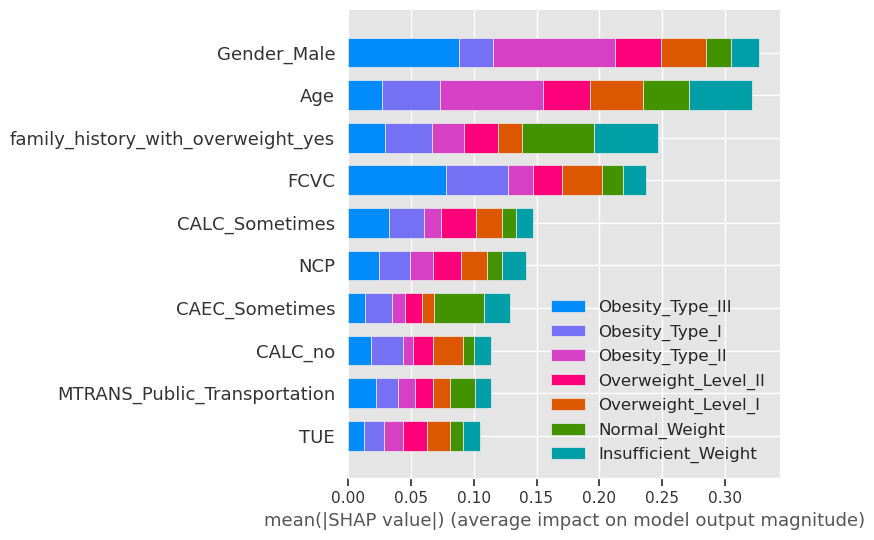

In [37]:
shap.summary_plot(shap_values, X_train, plot_type='bar', class_names=class_names, max_display=10)

# Regression

Regression is a statistical technique used to model the relationship between a dependent variable and one or more independent variables. 

In this study, a 'BMI' variable is created by dividing an individual's weight in kilograms by the square of their height in meters. This variable is then used as the target variable for regression analysis to identify the factors that contribute to obesity. 

To interpret the results of the regression analysis, the SHAP approach is again used. SHAP values are used to explain the contribution of each feature to the BMI of an individual. This helps to understand which features are most important in contributing to an individual's BMI.

## Preprocessing

In [38]:
X = df.drop(columns=["NObeyesdad"], axis=1)


In [39]:
X['BMI'] = df['Weight'] / df['Height']**2
X.drop(columns=["Weight", "Height"], axis=1, inplace=True)
X.head()

,Gender,Age,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,BMI
0,Female,21,yes,no,2,3,Sometimes,no,2,no,0,1,no,Public_Transportation,24.386526
1,Female,21,yes,no,3,3,Sometimes,yes,3,yes,3,0,Sometimes,Public_Transportation,24.238227
2,Male,23,yes,no,2,3,Sometimes,no,2,no,2,1,Frequently,Public_Transportation,23.765432
3,Male,27,no,no,3,3,Sometimes,no,2,no,2,0,Frequently,Walking,26.851852
4,Male,22,no,no,2,1,Sometimes,no,2,no,0,0,Sometimes,Public_Transportation,28.342381


> We created a **BMI** (Body Mass Index) feature using the following formula:
> 
> We then dropped the **Height** and **Weight** features.

In [40]:
# Split the data into features and target
y = X["BMI"]
X = X.drop("BMI", axis=1)

In [41]:
dummies_cols = X[["Gender","family_history_with_overweight",
                                          "FAVC","CAEC","SMOKE","SCC","CALC","MTRANS"]]

X_dummies = pd.get_dummies(dummies_cols,columns=["Gender","family_history_with_overweight",
                                          "FAVC","CAEC","SMOKE","SCC","CALC","MTRANS"], drop_first=True)

X_num = X.select_dtypes(include=['float64', 'int64'])


X = pd.concat([X_num, X_dummies], axis=1)
X.head()

,Age,FCVC,NCP,CH2O,FAF,TUE,Gender_Male,family_history_with_overweight_yes,FAVC_yes,CAEC_Frequently,...,CAEC_no,SMOKE_yes,SCC_yes,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,21,2,3,2,0,1,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0
1,21,3,3,3,3,0,0,1,0,0,...,0,1,1,0,1,0,0,0,1,0
2,23,2,3,2,2,1,1,1,0,0,...,0,0,0,1,0,0,0,0,1,0
3,27,3,3,2,2,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
4,22,2,1,2,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [42]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=23)

bold(f' X_train: {X_train.shape[0]}  |  y_train: {y_train.shape[0]}')
bold(f' X_test :  {X_test.shape[0]}  |  y_test: {y_test.shape[0]}')

 X_train: 1688  |  y_train: 1688

 X_test :  423  |  y_test: 423

In [43]:
#Scaling the numerical columns of train set and test set separatly to prevent data leakage
cols = ["Age", "FCVC", "NCP", "CH2O", "FAF", "TUE"]

std_scaler = StandardScaler()

X_train[cols] = std_scaler.fit_transform(X_train[cols])
X_test[cols] = std_scaler.transform(X_test[cols])

bold(f' X_train: {X_train.shape[0]}')
bold(f' X_test :  {X_test.shape[0]}')

 X_train: 1688

 X_test :  423

## Model Selection

In [44]:
%%time
random_state = 23

# create a list of regressors
regressors = [linear_model.LinearRegression(),
              linear_model.Ridge(),
              linear_model.Lasso(),
              linear_model.ElasticNet(),
              svm.SVR(),
              ensemble.RandomForestRegressor(random_state=random_state),
              ensemble.GradientBoostingRegressor(random_state=random_state),
              xgb.XGBRegressor(random_state=random_state),
              lgb.LGBMRegressor(random_state=random_state),
              neural_network.MLPRegressor(random_state=random_state)]

# create a list of regressors to evaluate
cv = KFold(n_splits=10, shuffle=True, random_state=23)

# define the metrics to be computed
scoring = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2']

# create table to compare MLA metrics
MLA_columns = ['Name','MAE','MAE_std','MSE','MSE_std','RMSE','RMSE_std','R-squared','R-squared_std','Fit Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

# perform cross-validation and compute metrics
row_index = 0
cv_results_list = []
for clf in regressors:
    cv_results = cross_validate(clf, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
    cv_results_list.append(cv_results)
    
    MLA_name = clf.__class__.__name__
    MLA_compare.loc[row_index, 'Name'] = MLA_name
    MLA_compare.loc[row_index, 'MAE'] = round(-cv_results['test_neg_mean_absolute_error'].mean(), 3)
    MLA_compare.loc[row_index, 'MAE_std'] = round(cv_results['test_neg_mean_absolute_error'].std(), 3)
    MLA_compare.loc[row_index, 'MSE'] = round(-cv_results['test_neg_mean_squared_error'].mean(), 3)
    MLA_compare.loc[row_index, 'MSE_std'] = round(cv_results['test_neg_mean_squared_error'].std(), 3)
    MLA_compare.loc[row_index, 'RMSE'] = round(np.sqrt(-cv_results['test_neg_mean_squared_error'].mean()), 3)
    MLA_compare.loc[row_index, 'RMSE_std'] = round(np.sqrt(cv_results['test_neg_mean_squared_error'].std()), 3)
    MLA_compare.loc[row_index, 'R-squared'] = round(cv_results['test_r2'].mean(), 3)
    MLA_compare.loc[row_index, 'R-squared_std'] = round(cv_results['test_r2'].std(), 3)
    MLA_compare.loc[row_index, 'Fit Time'] = round(cv_results['fit_time'].sum(), 3)
    
    
    print(f'{MLA_name} is done in {round(cv_results["fit_time"].sum(), 3)}')
    
    row_index+=1

MLA_compare.sort_values(by = ['RMSE'], ascending = True, inplace = True)
MLA_compare


LinearRegression is done in 0.086
Ridge is done in 0.07
Lasso is done in 0.068
ElasticNet is done in 0.067
SVR is done in 5.731
RandomForestRegressor is done in 15.837
GradientBoostingRegressor is done in 4.941
XGBRegressor is done in 18.179
LGBMRegressor is done in 2.302
MLPRegressor is done in 50.145
CPU times: user 632 ms, sys: 23.7 ms, total: 656 ms
Wall time: 28.2 s


,Name,MAE,MAE_std,MSE,MSE_std,RMSE,RMSE_std,R-squared,R-squared_std,Fit Time
5,RandomForestRegressor,2.013,0.136,10.288,1.9,3.208,1.378,0.839,0.036,15.837
8,LGBMRegressor,2.254,0.111,11.057,1.742,3.325,1.32,0.828,0.032,2.302
7,XGBRegressor,2.295,0.172,11.782,1.875,3.432,1.369,0.815,0.041,18.179
6,GradientBoostingRegressor,3.262,0.196,18.271,2.173,4.274,1.474,0.716,0.043,4.941
4,SVR,3.394,0.179,20.237,2.561,4.499,1.6,0.685,0.05,5.731
9,MLPRegressor,3.516,0.178,20.519,2.648,4.53,1.627,0.681,0.049,50.145
1,Ridge,4.689,0.186,34.039,2.727,5.834,1.651,0.471,0.054,0.07
0,LinearRegression,4.69,0.185,34.078,2.713,5.838,1.647,0.471,0.054,0.086
3,ElasticNet,5.978,0.397,51.477,5.696,7.175,2.387,0.207,0.02,0.067
2,Lasso,6.004,0.424,52.45,5.893,7.242,2.428,0.192,0.019,0.068


> We applied a 10 classification algorithms using 10 fold cross-validation on our training set, the results show clear superiority of ensemble methods over other methods.
> 
> We chose **RandomForestRegressor** and **LGBMRegressor** for further analysis.

## Hyperparameter Tuning

In [45]:
from sklearn.metrics import mean_squared_error

def objective(trial, mod, X_train, y_train, scorer= 'neg_mean_squared_error', folds=10):
    """
    THIS IS THE OBJECTIVE FUNCTION THAT RETURNS THE MEAN SCORES OF THE MODEL TO OPTUNA 
    FOR HYPERPARAMETER OPTIMIZATION
    """
    
    cv = KFold(n_splits=folds, shuffle=True, random_state=23)
    
    X = X_train.copy()
    y = y_train.copy()
    
    if mod == 'RF  ':
        n_estimators = trial.suggest_int('n_estimators', 50, 500)
        max_depth = trial.suggest_int('max_depth', 5, 50)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
        max_features = trial.suggest_int('max_features', 1, 8)
    
        model = ensemble.RandomForestRegressor(max_depth=max_depth,
                                                n_estimators=n_estimators,
                                                min_samples_split=min_samples_split,
                                                min_samples_leaf=min_samples_leaf,
                                                max_features=max_features,
                                                random_state=23)
        
    elif mod == 'LGBM':
        max_depth = trial.suggest_int("max_depth", 6, 20)
        n_estimators = trial.suggest_int("n_estimators", 100, 1000)
        learning_rate = trial.suggest_loguniform('learning_rate', 1e-8, 1)
        num_leaves = trial.suggest_int("num_leaves", 2, 3000)
        min_child_samples = trial.suggest_int('min_child_samples', 3, 200)
        min_child_weight = trial.suggest_loguniform('min_child_weight', 1e-5, 1)
        colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 1)
        subsample = trial.suggest_uniform('subsample', 0.1, 1)
        random_state = 23

        model = lgb.LGBMRegressor(learning_rate=learning_rate, 
                              n_estimators=n_estimators, 
                              max_depth=max_depth, 
                              num_leaves=num_leaves, 
                              min_child_samples=min_child_samples,
                              min_child_weight=min_child_weight,
                              colsample_bytree=colsample_bytree,
                              subsample=subsample,
                              random_state=23)

    elif mod == 'XGB ':
        max_depth = trial.suggest_int("max_depth", 2, 20)
        n_estimators = trial.suggest_int("n_estimators", 50, 1000)
        learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1)
        gamma = trial.suggest_loguniform("gamma", 1e-5, 1)
        subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
        colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
        random_state = 23

        model = xgb.XGBRegressor(max_depth=max_depth, 
                         learning_rate=learning_rate, 
                         n_estimators=n_estimators, 
                         gamma=gamma, 
                         subsample=subsample, 
                         colsample_bytree=colsample_bytree, 
                         random_state=23)
        
    # Cross validation of the model
    scores = cross_val_score(model, X, y, scoring=scorer, cv=cv, n_jobs=-1)

    # Return mean score and variance
    return scores.mean()


In [46]:
from optuna.samplers import TPESampler
from optuna import TrialPruned

def tune(objective, mod, X_train, y_train, scorer, n_trials=25, pruner=None):
    objective_func = lambda trial: objective(trial, mod, X_train, y_train, scorer)
    
    if scorer == 'neg_mean_squared_error':
        direction = 'minimize'
    else:
        direction = 'maximize'
    
    study = optuna.create_study(direction=direction, pruner=pruner, sampler=TPESampler(seed=23))
    study.optimize(objective_func, n_trials=n_trials, show_progress_bar=True)
    params = study.best_params
    best_score = study.best_value
    return params, best_score

In [47]:
%%time
import datetime
from optuna.pruners import MedianPruner
import optuna.logging
#optuna.logging.set_verbosity(optuna.logging.WARNING)


params = {'RF  ':'',
          #'LGBM':'',
          #'XGB ':''
         }
pruner = optuna.pruners.MedianPruner(n_warmup_steps=5, interval_steps=1)
for mod, param in params.items():
        start_time = time.time()
        tuned_params, top_score = tune(objective, mod, X_train, y_train, scorer='r2', n_trials=250, 
                                        pruner=pruner)
        params[mod] = tuned_params
        end_time = time.time()
        time_spent = datetime.datetime.utcfromtimestamp(end_time-start_time)
        time_str = time_spent.strftime('%H:%M:%S')
        print(f'Best score: {top_score:.5f}')
        print(f'| {mod} |{"-"*90}| {time_str} \n')

  0%|          | 0/250 [00:00<?, ?it/s]

Best score: 0.85611
| RF   |------------------------------------------------------------------------------------------| 00:44:21 

CPU times: user 27 s, sys: 1.03 s, total: 28 s
Wall time: 44min 21s


> Following the results of the hyperparameter tuning, the **RandomForestRegressor** model has improved.

In [48]:
bold(f"the best parameters for our random forest are :")
print(params['RF  '])

the best parameters for our random forest are :

{'n_estimators': 418, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 6}


In [49]:
# create a list of regressors
regressors = [ensemble.RandomForestRegressor(random_state=random_state)]

# create a list of regressors to evaluate
cv = KFold(n_splits=10, shuffle=True, random_state=23)

# define the metrics to be computed
scoring = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2']

# perform cross-validation and compute metrics
cv_results = cross_validate(regressors[0].set_params(**params['RF  ']), X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)

name = '10 CV Score'
cv_mse = round(-cv_results['test_neg_mean_squared_error'].mean(), 3)
cv_mae = round(-cv_results['test_neg_mean_absolute_error'].mean(), 3)
cv_r2 = round(cv_results['test_r2'].mean(), 3)

# retrain the best model on the full training set using the tuned parameters
best_model = ensemble.RandomForestRegressor(random_state=random_state).set_params(**params['RF  '])
best_model.fit(X_train, y_train)

# compute test set metrics using the best model
y_pred = best_model.predict(X_test)
name = 'Test Score'
test_mse = round(mean_squared_error(y_test, y_pred), 3)
test_mae = round(mean_absolute_error(y_test, y_pred), 3)
test_r2 = round(r2_score(y_test, y_pred), 3)

# comparison
print(f"           |  cv   | test  |")
print(f"MSE:       | {cv_mse}  | {test_mse} |")
print(f"MAE:       | {cv_mae} | {test_mae} |")
print(f"R2 Score:  | {cv_r2} | {test_r2} |")


           |  cv   | test  |
MSE:       | 9.21  | 7.909 |
MAE:       | 2.014 | 1.884 |
R2 Score:  | 0.856 | 0.867 |


## Interpretation

In [50]:
# calculate SHAP values
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_train)

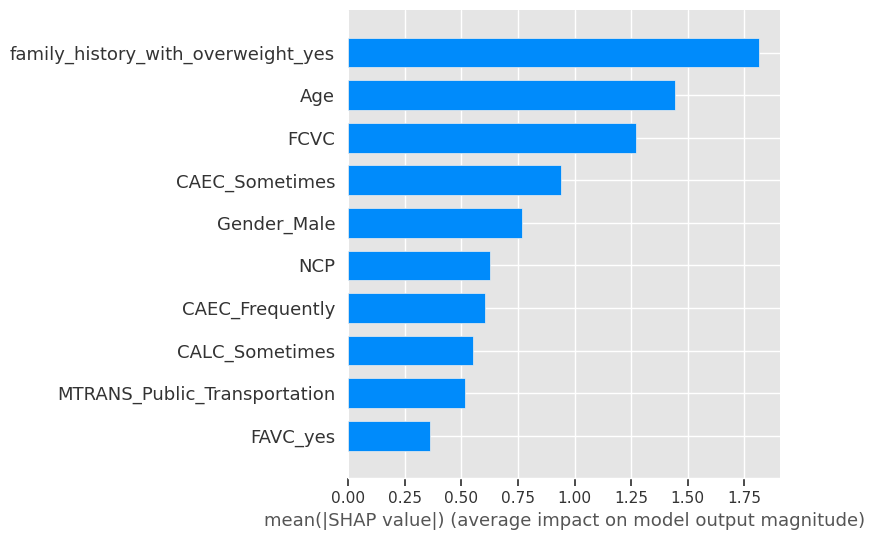

In [51]:
# generate summary plot
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=10)

# Conclusion

After conducting PCA, Classification, and Regression analyses on the UCI Obesity Dataset, it can be concluded that several factors have been identified as significant predictors of obesity. The results show that family history with overweight, age, frequency of consumption of vegetables, and gender are the most important factors that affect and can predict obesity.

The family history with overweight, which indicates whether a person has a family history of being overweight, has a significant impact on obesity. This result suggests that individuals with a family history of obesity may have a higher risk of developing obesity themselves.

Age is another important predictor of obesity. The older an individual is, the higher the likelihood of them being obese. This result is consistent with previous studies that have identified age as a significant risk factor for obesity.

The frequency of consumption of vegetables (FCVC) is another factor that significantly affects obesity. This result suggests that individuals who consume vegetables more frequently have a lower risk of obesity compared to those who consume them less frequently.

Finally, the analysis showed that gender is also an important factor in predicting obesity. Females were found to be more likely to be obese than males. This result is consistent with previous studies that have identified gender as a significant risk factor for obesity.

In conclusion, by using the PCA, Classification, and Regression, we have identified several factors that significantly affect and predict obesity. These results can be useful in developing effective interventions and strategies to prevent and manage obesity.
